In [135]:
import pandas as pd 

#Loading data
data = pd.read_csv("../data/example.csv")

race = data["race"]
religion = data["religion"]
country = data["country"]
cr_t = data["time_criminal"]
toxic_t = data["time_toxic"]
tests = []
tests.append(data["test_1"])
tests.append(data["test_2"])
tests.append(data["test_3"])
tests.append(data["test_4"])
tests.append(data["test_5"])
tests.append(data["test_6"])
tests.append(data["test_7"])

#Filtering out test according to the quality control
#The test with the golden question
golden_test = 3
#The tests that are shuffled version of the same models ()
same_model_1 = 0
same_model_2 = 5

num_tests = len(tests)
num_data = len(tests[0])

filtered_tests = []
for i in range(num_tests):
    filtered_tests.append([])
    
for i in range(num_data):
    if tests[golden_test][i] == 5 and tests[same_model_1][i] == tests[same_model_2][i]:
        for j in range(num_tests):
            filtered_tests[j].append(tests[j][i]) 
 
#print(filtered_tests)
#Uncomment to add quality control
#tests = filtered_tests
num_data = len(tests[0])

#Calculating task times   
avg_cr_t = 0
for t in cr_t:
    avg_cr_t += t
avg_cr_t = avg_cr_t / len(cr_t)

avg_toxic_t = 0
for t in toxic_t:
    avg_toxic_t += t
avg_toxic_t = avg_toxic_t / len(toxic_t)

print("The average finish time of criminal justice task: " + str(avg_cr_t))
print("The average finish time of toxic comments task: " + str(avg_toxic_t))

#Calculating the number of don't know answers
counts = [0] * num_data
for i in range(num_tests):
    for j in range(num_data):
        if tests[i][j] == 3:
            counts[j] += 1

avg_dont_know = 0
for j in range(num_data):
    avg_dont_know += counts[j]
    
avg_dont_know = avg_dont_know / num_data

print("The average number of don't know answers: " + str(avg_dont_know))


The average finish time of criminal justice task: 575.3333333333334
The average finish time of toxic comments task: 596.6666666666666
The average number of don't know answers: 3.0


In [136]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

#Function for plotting the fairness of models according to workers 
def plot_fairness(j, filt_country, filt_religion, filt_race):
    prefer_A = 0
    prefer_A_l = 0
    dont_know = 0
    prefer_B_l = 0
    prefer_B = 0

    num_passed = 0
    for i in range(num_data):
        pass_country = True
        if filt_country:
            pass_country = False
            for filt in filt_country:
                if country[i] == filt:
                    pass_country = True
                    
                    
        pass_religion = True            
        if filt_religion:        
            pass_religion = False        
            for filt in filt_religion:
                if religion[i] == filt:
                    pass_religion = True
        
        pass_race = True
        if filt_race:
            pass_race = False        
            for filt in filt_race:
                if race[i] == filt:
                    pass_race = True      
            
        if pass_country and pass_religion and pass_race:
            num_passed += 1
            x = tests[j][i]
            if x == 1:
                prefer_A += 1 
            if x == 2:
                prefer_A_l += 1
            if x == 3:
                dont_know += 1
            if x == 4:
                prefer_B_l += 1
            if x == 5:
                prefer_B += 1

    prefer_A = prefer_A / num_passed
    prefer_A_l = prefer_A_l / num_passed
    dont_know = dont_know / num_passed
    prefer_B_l = prefer_B_l / num_passed
    prefer_B = prefer_B / num_passed
    
    #print(prefer_A)
    #print(prefer_A_l)
    #print(dont_know)
    #print(prefer_B_l)
    #print(prefer_B)

    fig, ax = plt.subplots()
    ax.broken_barh([(0, prefer_A), 
                    (prefer_A, prefer_A+prefer_A_l), 
                    (prefer_A+prefer_A_l, 
                     prefer_A+prefer_A_l+dont_know),
                    (prefer_A+prefer_A_l+dont_know, 
                     prefer_A+prefer_A_l+dont_know+prefer_B_l),
                    (prefer_A+prefer_A_l+dont_know+prefer_B_l,
                     prefer_A+prefer_A_l+dont_know+prefer_B_l+prefer_B)], [10, 9], 
                     facecolors=('#6259D8', '#E53F08', '#FDB200', '#3FE03D', '#1EE8D4'))

    ax.set_ylim(5, 15)
    ax.set_xlim(0, 1)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticks([15, 25])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])

    ax.set_axisbelow(True) 

    ax.set_yticklabels(['Test ' + str(j+1)])
    ax.grid(axis='x')
    
    
    fig.suptitle('Fairness Test ' + str(j+1), fontsize=16)

    leg1 = mpatches.Patch(color='#6259D8', label='Model A is much fairer')
    leg2 = mpatches.Patch(color='#E53F08', label='Model A fairer')
    leg3 = mpatches.Patch(color='#FDB200', label='Don\'t know')
    leg4 = mpatches.Patch(color='#3FE03D', label='Model B is fairer')
    leg5 = mpatches.Patch(color='#1EE8D4', label='Model B is much fairer')
    ax.legend(handles=[leg1, leg2, leg3, leg4, leg5], ncol=2)

    plt.show()
    

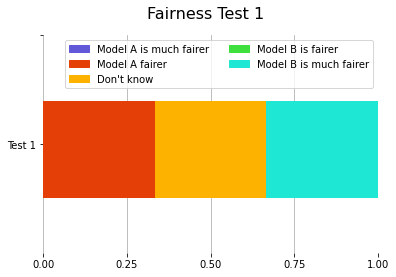

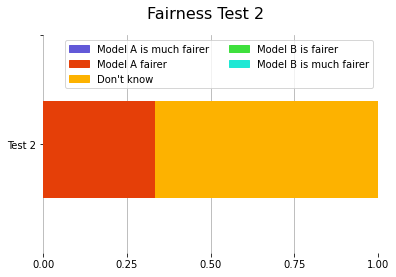

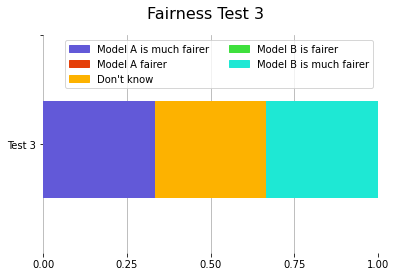

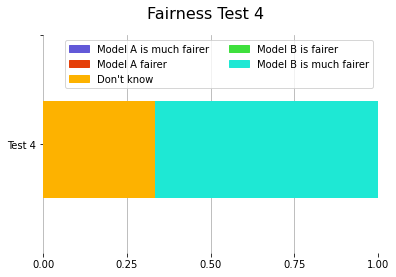

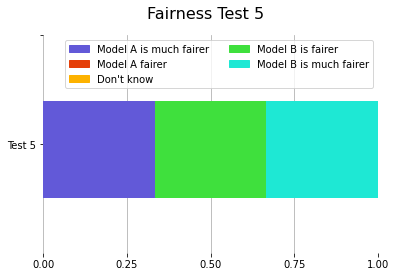

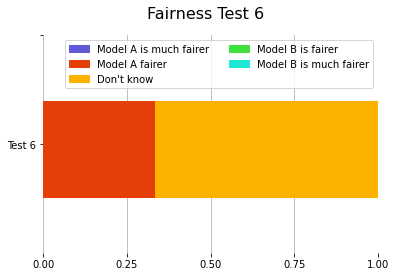

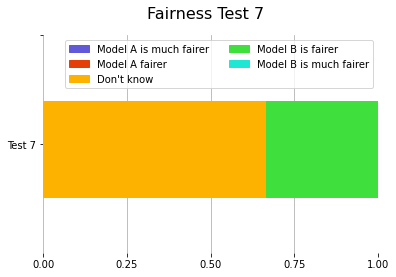

In [137]:
#Plot for all people
for j in range(num_tests):
    plot_fairness(j, [], [], [])

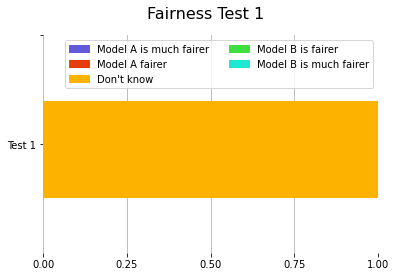

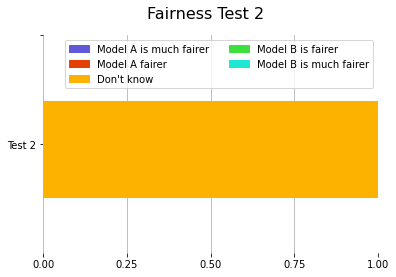

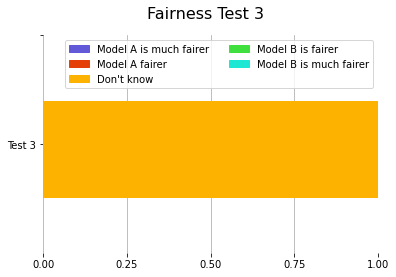

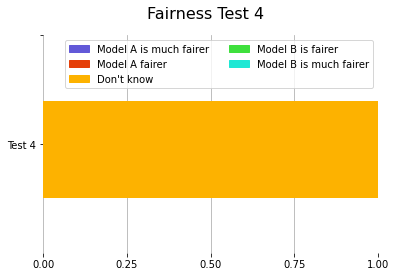

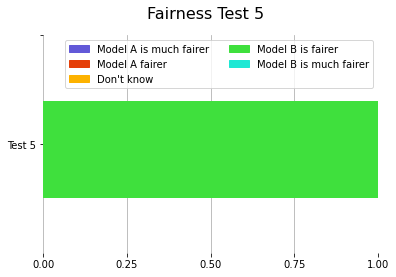

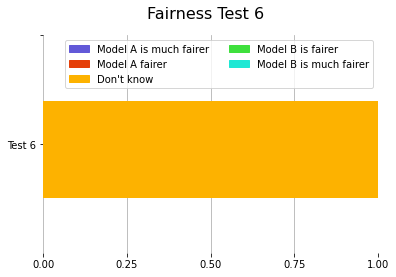

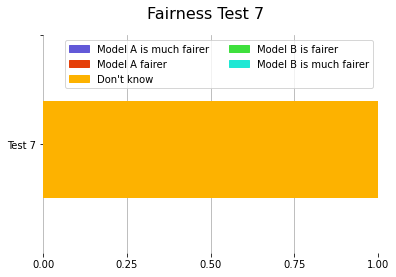

In [139]:
#Plot for Finnish Christian
#To filter out demographics: 
#the first list is to only allow people from certain countries
#the second list is to only allow people with certain religions
#the third list is to only allow people with certain races
#Empty lists means every demograhic is allowed
for j in range(num_tests):
    plot_fairness(j, ["Finland"], ["Christian"], [])
